# RNA-Seq Differential Expression (DE) Analysis Using baySeq

Thomas J. Hardcastle (2019). baySeq: Empirical Bayesian analysis of
  patterns of differential expression in count data. R package version
  2.18.0.
The original paper from Hardcastle & Kelly introducing the concepts implemented in this package is available here 
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-422

We will be using the pasilla package for our example data which is cited here.
 Wolfgang Huber and Alejandro Reyes (2019). pasilla: Data package with
  per-exon and per-gene read counts of RNA-seq samples of Pasilla
  knock-down by Brooks et al., Genome Research 2011.. R package version
  1.12.0.
  
Data for the package is part of this paper: 
"Conservation of an RNA regulatory map between Drosophila and mammals" by Brooks AN, Yang L, Duff MO, Hansen KD, Park JW, Dudoit S, Brenner SE, Graveley BR, Genome Res. 2011 Feb;21(2):193-202, Epub 2010 Oct 4, PMID: 20921232. 

Briefly, baySeq uses empirical Bayesian inference to determine the likelihood that genes in compared samples are indeed DE genes. baySeq improve seeks to improve accuracy in DE estimation over other popular packages by using the underlying structure of the data itself. baySeq does show improved performance in the case of more complex study designs (i.e. multiple group comparisons) and in studies with large numbers of libraries compared to other popular packages. Here we illustrate a simplified example of a comparison between a control and a treatment group.

Imagine you want to place a bet on whether it will rain later today. What kind of information do you think would help you make the most accurate bet, a coin toss or accounting for humidity, cloud cover, or season? Bayesian inference represents the latter.

### Definition of terms

###### Bayesian statistics: 
Learning from experience to make inferences about the relationship between our variables of interest. While the null hypothesis in the frequentist approach (i.e. the use of p values) says that "there is no relationship", the Bayesian approach allows us to incorporate previous knowledge we may have about a relationship into future research we want to do on it. The associated credible interval (as compared to the confidence interval) tells us how likely it is that a particular value of interest lies between the prior and posterior estimates of that value. In our example we would interpret this as, given what we know about genetic expression between our control and treatment groups, how likely it is that a certain percentage of genes are DE genes?
<br>
###### Prior probability: 
The information we have about our data before we see it. This could come from what we know about similar experiments or we can estimate it from our data and these options vary in their utility. In our example, this could refer to how likely we think it is that a certain percentage of genes are DE between our control and treatment groups.
<br>
###### Posterior probability:
The results of incorproating our prior knowledge and our observed data. In our case that means, given that our control and treatment samples have particular genes with particular amounts of expression, how likely it is that a certain percentage of genes between them are DE genes?

For more information and the source for these definitions please see "A Gentle Introduction to Bayesian Analysis" from Schoot, Kaplan, Denissen, Asendorpf, Neyer, and Aken (Developmental Method, 2013) https://onlinelibrary.wiley.com/doi/full/10.1111/cdev.12169

Our very first step is to load the baySeq and pasilla packages from Bioconductor use an R cluster to parallelize our work. Please see http://bioconductor.org/ for information about installation and use of Bioconductor and its packages.

In [2]:
library(baySeq)
library (pasilla)
if(require("parallel")) cl <- makeCluster(8) else cl <- NULL

### Load example dataset
Our example data are from the pasilla package available on Bioconductor. The experiment studied RNAi knockdown of Pasilla, the Drosophila melanogaster ortholog of mammalian NOVA1 and NOVA2, on the transcriptome. Data are provided by NCBI Gene Expression Omnibus under accession numbers GSM461176 to GSM461181.

Please reach out to EICC if you would like to compare 3 or more groups as this is a simplified example. It may also be the case you will need more than 6 samples per experimental group or that you may need to remove genes with average counts greater than 5, 10, 15, or even 20 for sufficient statistical power. Please see our PROPER walkthrough for an example of our of power and sample size analysis.

In [5]:
countdata <- system.file("extdata",
                      "pasilla_gene_counts.tsv",
                      package="pasilla", mustWork=TRUE)

countdata <- as.matrix(read.csv(countdata,sep="\t",row.names="gene_id"))

### Labelling replicates and specifying our hypothesis
<br>
After that, we label our samples correctly and specify our hypothesis. 

In our case, our replicates are organized in our csv file above such that the first 4 columns are untreated samples and the latter 3 columns are treated samples. This is how we label the replicates in the model.

The groups object specifies our hypothesis. In the null hypothesis of no differential expression (NDE), if all of our samples are 1's, this means that all of the samples belonging to the same group, there is no difference between the treated and untreated samples. In the alternative hypothesis of differential expression, (DE) 1's represent membership in a single group and 2's represent membership in a second group. This set of 4 1's and 3 2's says that there exist two distinct patterns of expression in the control and treatment groups.

In [6]:
replicates <- c("Untreated","Untreated","Untreated","Untreated",
                "Treated","Treated","Treated")

groups<- list(NDE = c(1,1,1,1,1,1,1),
               DE = c(1,1,1,1,2,2,2))

### Preparation for Differential Expression Analysis
In order to perform our pairwise comparison we need to specify some informaton about our data. Replicates and Groups represent the labels for our replicates (Control vs. Treatment) and the null (NDE) and alternative (DE) hypotheses we specified above. We also annotate all 13064 genes with a number to cross-reference with the list of gene names and counts after analysis. Our final preparation step is to get our library size. Sometimes you may already know this but we have inferred it from the data.

In [9]:
CD <- new("countData", data = countdata, replicates = replicates, groups = groups)
libsizes(CD) <- getLibsizes(CD)
CD@annotation <-data.frame(name = rownames(countdata))

### Determine prior probabilities
<br>
We determine the prior probabilities of DE from the count data. Recall that this means we are incorporating some structure inherent in our data to inform the likeliehood that there are DE genes between our two groups. 
<br>
<br>
For our simplified example we have chosen to do 10000 bootstrap samples using quasi-likelihood estimation.These parameters will vary by experiment and we would tailor these to your specific project.The length of time that determining the priors and posterior likelihoods will take depends on your computational power, your sample size, the method of estimation, the number of genes, number of samples, and the number of groups you are comparing.

In [10]:
start_time <- Sys.time()
CD <- getPriors.NB(CD, samplesize = 10000, estimation = "QL", cl = cl)
end_time <- Sys.time()

end_time - start_time

Finding priors...done.


Time difference of 4.277674 mins

### Determine posterior likelihoods
<br>
Next, we determine the posterior likelihood, that is, we are using our prior knowledge and looking at our existing data to estimate how likely is it that there are DE genes between our two groups?

We chose to use just 3 bootstrap estimates here in the interest of the accuracy vs. time trade-off. We would assess this parameter based on your specific experiment.

In [11]:
start_time <- Sys.time()
CD <- getLikelihoods(CD, bootStraps = 3, verbose = FALSE, cl = cl)
end_time <- Sys.time()
end_time - start_time

Length of priorReps:10010
Length of priorSubset:14599
Length of subset:14599
Length of postRows:14599


...

Time difference of 13.29088 mins

### Summarize Results

Here we have the list of top 10 genes which are most likely to be differentially expressed at FDR controlled at 0.05. This cut-off may vary anywhere from 0.01-0.2 and will depend on the individual experiment but should be specified a priori. We can see that the very first gene, FBgn002511 is significantly up regulated in the treated as compared to the untreated samples whereas FBgn0039155 is significantly up regulated in the untreated samples as compared to the treated samples.  

In [22]:
head(topCounts(CD, group="DE", normaliseData=TRUE, FDR=0.05))

,name,untreated1,untreated2,untreated3,untreated4,treated1,treated2,treated3,likes,DE,FDR.DE,FWER.DE
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>
2366,FBgn0025111,451,653,279,306,4186,2381,2686,1.0000000,2>1,2.479510e-09,2.479510e-09
9831,FBgn0039155,1527,2220,741,931,70,38,52,1.0000000,1>2,5.009191e-09,1.001838e-08
6948,FBgn0035085,1176,1579,651,785,245,135,150,1.0000000,1>2,9.268608e-09,2.780582e-08
10305,FBgn0039827,478,678,319,353,35,14,29,1.0000000,1>2,1.448238e-08,5.792952e-08
6711,FBgn0034736,366,645,286,271,47,27,29,0.9999996,1>2,8.748318e-08,4.374159e-07
11422,FBgn0051092,64,103,38,39,436,220,243,0.9999995,2>1,1.619840e-07,9.719035e-07


### Visualization
<br>
Finally, we can graph what we see. Here is one example of a plot we could make for you called an MA-plot where the x axis is the mean gene expression and the y axis is the log2 transformed fold change. Truly DE genes are in red and non-DE genes are in black.

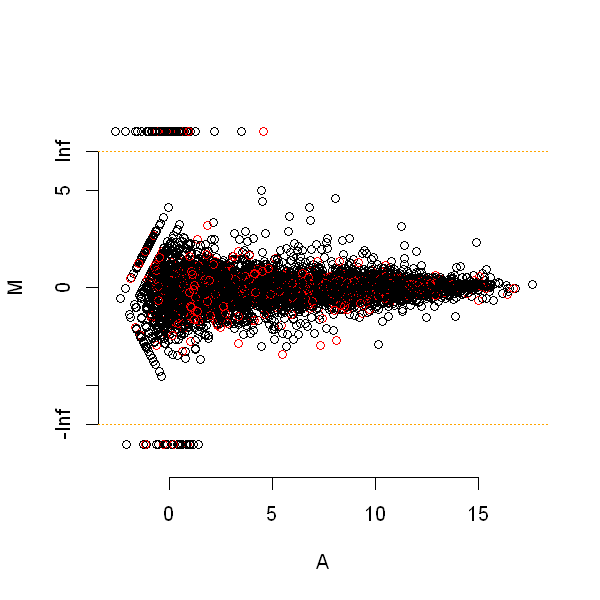

In [16]:
options(repr.plot.width=5, repr.plot.height=5)
plotMA.CD(CD, samplesA = "Untreated", samplesB = "Treated", col = c(rep("red", 100), rep("black", 900)))

There are many options for assessing and graphing the results of DE analysis in baySeq.Further, there are many more functions and many more specifications to functions than are used here in order to show a simplified example of one of the tools we use.
Obtaining specific, actionable, and publication quality results from analysis requires a deeper understanding of your specific data set and we would love the opportunity to discuss these options with you. 

While we encourage clients to reach out prior to sequencing so that we can collaborate to design the experiment to answer your specific questions, we look forward to hearing from you at any stage of your RNA-seq project. Please find our contact information available here https://www.cores.emory.edu/eicc/about/index.html

Session information available below 

In [47]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 18362)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] tseries_0.10-47      future_1.14.0        baySeq_2.18.0       
 [4] abind_1.4-5          GenomicRanges_1.36.0 GenomeInfoDb_1.20.0 
 [7] IRanges_2.18.1       S4Vectors_0.22.0     BiocGenerics_0.30.0 
[10] edgeR_3.26.6         limma_3.40.5         BiocManager_1.30.4  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.2             pillar_1.4.2           compiler_3.6.0        
 [4] XVector_0.24.0         xts_0.11-2             base64enc_0.1-3       
 [7] bitops_1.0-6     